<h1>Problem Statement</h1> 
<p><i>For easy reference</i></p>
<p>Objective: develop a model that recommends the best financial advisors for individual customers through various techniques such as recommendation systems, supervised learning models, or unsupervised learning models. Used to assign the most suitable financial advisors to customers.</p>

In [189]:
import pandas as pd 
import os #for reading files
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import seaborn as sns
from surprise import Dataset, Reader, SVD, accuracy
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

path = "./final_nus_datathon_dataset"

In [190]:
#!pip install pyarrow 
#^if you need to install pyarrow uncomment
# !pip3 install imbalanced-learn


<h3>Load Data</h3>

In [191]:
dfs = dict()
files = os.listdir(path)

print("Naming Convention:")
for i in range(len(files)):
    _,*filename,_,_ = files[i].split("_") 
    dfs[filename[0]] = pd.read_parquet(f"{path}/{files[i]}") 
    print("dfs[\"",filename[0],"\"]", ":", files[i])
               


Naming Convention:
dfs[" policy "] : nus_policy_info_df.parquet
dfs[" client "] : nus_client_info_df.parquet
dfs[" final "] : sample_final_modelling_df.parquet
dfs[" agent "] : nus_agent_info_df.parquet


<h3>Description of Dataset</h3>
<p>I just put the table from the Problem Statemen docs under each respective dataset for easy ref</p>

In [192]:
dfs["policy"].head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_age_at_purchase_grp,cust_tenure_at_purchase_grp
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,prod_8,1,0,1,0,0,0,1,PG:0,AG05_35to39,TNR2_lt1yr
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,prod_8,1,0,1,0,0,0,1,PG:0,AG04_30to34,TNR4_4to8yr
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,prod_6,1,0,1,0,0,0,1,PG:0,AG07_45to49,TNR4_4to8yr


<table>
<thead>
<tr><th>Column Name</th><th>Purpose</th></tr>
</thead>
<tbody>
<tr><td>chdrnum</td><td> unique identifier for policy</td></tr>
<tr><td>agntnum</td><td> unique identifier for agent</td></tr>
<tr><td>secuityno</td><td> unique identifier for customer</td></tr>
<tr><td>occdate</td><td> inception date of policy</td></tr>
<tr><td>annual_premium</td><td> annual premium</td></tr>
<tr><td>product</td><td> product of the policy</td></tr>
<tr><td>product_grp </td><td> product group of the policy</td></tr>
<tr><td>flg_main </td><td> flag indicating the main policyholder</td></tr>
<tr><td>flg_inforce </td><td> flag indicating a policy that is in force</td></tr>
<tr><td>flg_cancel </td><td> flag indicating a policy that is cancelled</td></tr>
<tr><td>flg_expire </td><td> flag indicating a policy that expired</td></tr>
<tr><td>flg_converted </td><td> flag indicating a policy that is converted</td></tr>
<tr><td>cust_age_purchase_grp</td><td> customer's age group at purchase</td></tr>
<tr><td>cust_teure_at_purchase_grp</td><td> customer's tenure at purchase</td></tr>
</tbody>
</table>

In [193]:
dfs["agent"].head()

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]"
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6]
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4]
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]"
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]"


<table>
<thead>
<tr><th>Column Name</th><th>Purpose</th></tr>
</thead>
<tbody>
<tr><td>agent_age</td><td> agent’s age </td></tr>
<tr><td>agent_gender</td><td> agent’s gender </td></tr>
<tr><td>agent_marital</td><td> agent’s marital status </td></tr>
<tr><td>agent_tenure</td><td> agent’s tenure with the company </td></tr>
<tr><td>cnt_converted</td><td> count of policies converted by agent </td></tr>
<tr><td>annual_premium_cnvrt</td><td> total annual premium from converted policies by agent </td></tr>
<tr><td>pct_lapsed</td><td> percentage of policies that are currently lapsed </td></tr>
<tr><td>pct_cancel</td><td> percentage of policies that are currently cancelled </td></tr>
<tr><td>pct_inforce</td><td> percentage of policies that are currently in force </td></tr>
<tr><td>Percentage of customers’ gender handled by the agent</td><td> pct_sx0_unknown, pct_sx1_male, pct_sx2_female </td></tr>

<tr><td>Percentage of products sold by agent</td><td> pct_prod_0_cnvrt, pct_prod_1_cnvrt, ..., pct_prod_9_cnvrt</td></tr>

<tr><td>Percentage of customers’ age groups handled by the agent</td><td> pct_ag01_lt20, pct_ag02_20to24, ..., pct_ag10_60up </td></tr>
<tr><td>cluster</td><td> an old segment that the agent belongs to </td></tr>
<tr><td>agent_product_expertise</td><td> a list of products the agent is comfortable selling (based on feedback) </td></tr>
</tbody>
</table>


In [194]:
dfs["client"].head()

,secuityno,cltsex,cltdob,marryd,race_desc_map,cltpcode,household_size,economic_status,family_size,household_size_grp,family_size_grp
0,CIN:14264,F,1993-02-17,M,Chinese,545686,1,76,56,HH1_lt40,FS3_40to60
1,CIN:7188,F,1977-06-15,M,Chinese,308364,72,96,90,HH2_40to80,FS5_80up
2,CIN:13608,F,1998-02-12,S,Chinese,387393,28,93,23,HH1_lt40,FS2_20to40
3,CIN:5087,F,1972-10-25,M,Chinese,640469,84,51,34,HH3_80to100,FS2_20to40
4,CIN:18531,M,1984-12-27,M,Others,763318,92,18,73,HH3_80to100,FS4_60to80


<table>
<thead>
<tr><th>Column Name</th><th>Purpose</th></tr>
</thead>
<tbody>
<tr><td>secuityno</td><td> unique identifier for customer</td></tr>
<tr><td>cltsex</td><td> gender of customer</td></tr>
<tr><td>cltdob</td><td> date of birth of customer</td></tr>
<tr><td>marryd</td><td> marital status of customer</td></tr>
<tr><td>race_desc_map</td><td> race of customer</td></tr>
<tr><td>cltpcode</td><td> customer postal code</td></tr>
<tr><td>household_size</td><td> household size (based on postal code)</td></tr>
<tr><td>economic_status</td><td> economic status (based on postal code)</td></tr>
<tr><td>family_size</td><td> family size (based on postal code)</td></tr>
<tr><td>household_size_grp</td><td> discretized household size of customer</td></tr>
<tr><td>family_size_grp</td><td> discretized family size of customer</td></tr>
</tbody>
</table>

In [195]:
#removing NAs
for name in dfs:
    rows_before = len(dfs[name])
    dfs[name] = dfs[name].dropna() 
    rows_after = len(dfs[name])
    print(f"Dataset '{name}': Before {rows_before} After {rows_after}")

print("complete")

Dataset 'policy': Before 29503 After 29503
Dataset 'client': Before 20000 After 19647
Dataset 'final': Before 29503 After 29477
Dataset 'agent': Before 10129 After 10117
complete


<h2>EDA for Client Dataframe</h2>
<p>Can explore one hot encoding</p>

In [196]:
dfs["client"].head(3)

,secuityno,cltsex,cltdob,marryd,race_desc_map,cltpcode,household_size,economic_status,family_size,household_size_grp,family_size_grp
0,CIN:14264,F,1993-02-17,M,Chinese,545686,1,76,56,HH1_lt40,FS3_40to60
1,CIN:7188,F,1977-06-15,M,Chinese,308364,72,96,90,HH2_40to80,FS5_80up
2,CIN:13608,F,1998-02-12,S,Chinese,387393,28,93,23,HH1_lt40,FS2_20to40


In [197]:
#Unique values per df
#Client 
print("Unique values per column in Client")
for col in ["marryd","household_size_grp","family_size_grp"]:
    print(len(dfs["client"][col].unique()), f"for {col}")
    print(dfs["client"][col].unique())
    print("-"*6)


Unique values per column in Client
6 for marryd
['M' 'S' 'D' 'U' 'W' 'P']
------
6 for household_size_grp
['HH1_lt40' 'HH2_40to80' 'HH3_80to100' 'HH4_100to120' 'HH5_120up'
 'HH0_missing']
------
6 for family_size_grp
['FS3_40to60' 'FS5_80up' 'FS2_20to40' 'FS4_60to80' 'FS1_lt20'
 'FS0_missing']
------


In [198]:
#Encode sex, marryd, race, HH_Size, Family_Size

dfs["client_encoded"] = dfs["client"].copy()
family_cat = [[ 'FS0_missing','FS1_lt20', 'FS2_20to40','FS3_40to60','FS4_60to80' ,'FS5_80up']]
household_cat = [['HH0_missing','HH1_lt40', 'HH2_40to80', 'HH3_80to100', 'HH4_100to120', 'HH5_120up']]

col = "household_size_grp"
encoder = OrdinalEncoder(categories=household_cat)
dfs["client_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["client_encoded"][[col]])
col = "family_size_grp"
encoder = OrdinalEncoder(categories=family_cat)
dfs["client_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["client_encoded"][[col]]) 
dfs["client_encoded"].drop(columns=["family_size_grp","household_size_grp"], inplace=True)


for col in ["cltsex","marryd","race_desc_map"]: 
    encoder = LabelEncoder()
    dfs["client_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["client_encoded"][col])
    dfs["client_encoded"].drop(columns=[col],inplace=True)


In [199]:
dfs["client_encoded"].head(3)

,secuityno,cltdob,cltpcode,household_size,economic_status,family_size,household_size_grp_encoded,family_size_grp_encoded,cltsex_encoded,marryd_encoded,race_desc_map_encoded
0,CIN:14264,1993-02-17,545686,1,76,56,1.0,3.0,0,1,0
1,CIN:7188,1977-06-15,308364,72,96,90,2.0,5.0,0,1,0
2,CIN:13608,1998-02-12,387393,28,93,23,1.0,2.0,0,3,0


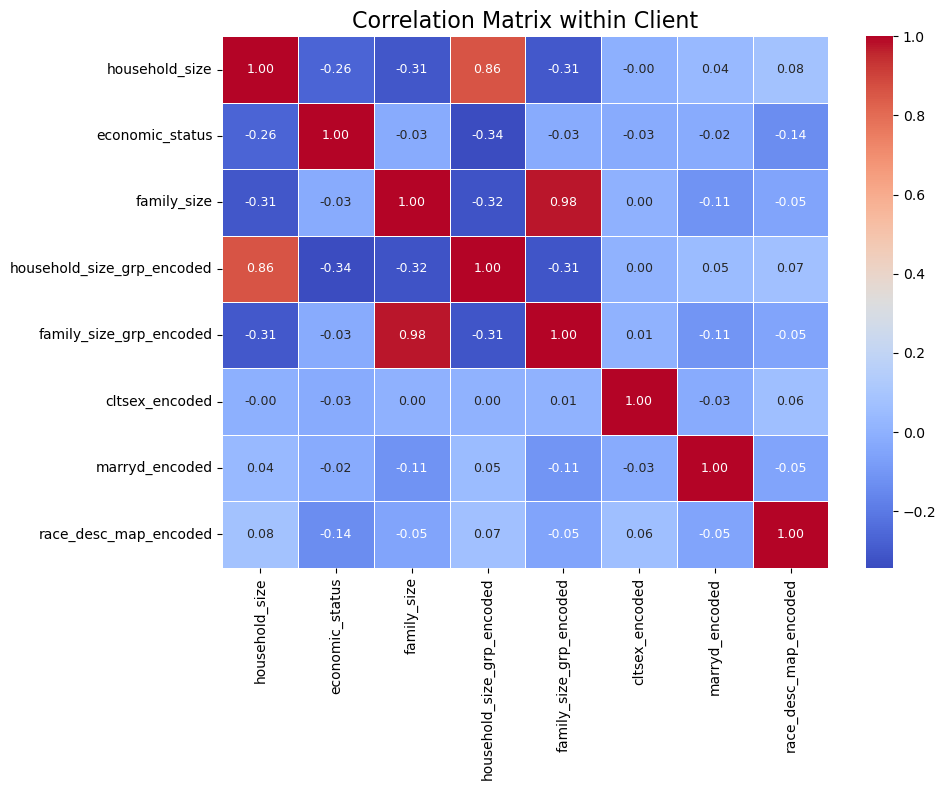

We can drop either the grouped column or its counterpart for client


In [200]:
# dfs["client_encode_test"].iloc[:,6:].head()
correlation_matrix = dfs["client_encoded"].iloc[:,3:].astype(float).corr()



plt.figure(figsize=(10, 8)) 
sns.heatmap(
    correlation_matrix,
    annot=True, 
    fmt=".2f",  
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 9} 
)
plt.title("Correlation Matrix within Client", fontsize=16)  
plt.tight_layout()  
plt.show()
print("We can drop either the grouped column or its counterpart for client")

In [201]:
dfs["client_encoded"].drop(columns=["family_size","household_size"], inplace=True) #drop these since clusters easier to classify (and less variations)

In [202]:
dfs["client_encoded"]["client_age"] = 2024 - dfs["client_encoded"]["cltdob"].dt.year
# dfs["client_encoded"].drop(columns=["cltdob"],inplace=True)

In [203]:
print("Initial Client df columns:", len(dfs["client"].columns), "vs. Encoded columns:",len(dfs["client_encoded"].columns))
print("Features in hh size:", len(dfs["client"]["household_size"].unique()), "vs. hh size grp:", len(dfs["client_encoded"]["household_size_grp_encoded"].unique()))

Initial Client df columns: 11 vs. Encoded columns: 10
Features in hh size: 348 vs. hh size grp: 6


<h2>EDA for Agents</h2>

In [204]:
pd.set_option('display.max_columns',None)
dfs["agent"].head()

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]"
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6]
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4]
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]"
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]"


In [205]:
dfs["agent"].head()

,agntnum,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise
0,AIN:9513,32.0,M,M,15.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,"[prod_2, prod_6]"
1,AIN:4310,40.0,M,M,18.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,[prod_6]
2,AIN:4302,39.0,F,M,40.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,[prod_4]
3,AIN:4996,57.0,F,D,41.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,"[prod_7, prod_9, prod_6, prod_0, prod_2]"
4,AIN:3457,38.0,M,M,62.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,"[prod_6, prod_8]"


In [206]:
dfs["agent_encoded"] = dfs["agent"].copy()

# Label Encoding for categorical agent attributes
for col in ["agent_gender", "agent_marital"]: 
    encoder = LabelEncoder()
    dfs["agent_encoded"][f"{col}_encoded"] = encoder.fit_transform(dfs["agent_encoded"][col])

# Define bins and labels for `agent_tenure` (to match customer tenure format)
bins = [0, 5, 15, 40, dfs["agent_encoded"]["agent_tenure"].max()]  # Define logical breakpoints
labels = ["TNR2_lt5yr", "TNR3_5to15yr", "TNR4_15to40yr", "TNR5_40yrup"]  # Categories aligned with customer tenure

# Convert agent_tenure from integers into tenure categories
dfs["agent_encoded"]["agent_tenure_grp"] = pd.cut(dfs["agent_encoded"]["agent_tenure"], bins=bins, labels=labels)

# Ensure categorical dtype before encoding
dfs["agent_encoded"]["agent_tenure_grp"] = dfs["agent_encoded"]["agent_tenure_grp"].astype("category")

# Handle NaNs by adding a placeholder category
dfs["agent_encoded"]["agent_tenure_grp"] = dfs["agent_encoded"]["agent_tenure_grp"].cat.add_categories(["Unknown"]).fillna("Unknown")

# Apply Ordinal Encoding
encoder = OrdinalEncoder(categories=[["Unknown", "TNR2_lt5yr", "TNR3_5to15yr", "TNR4_15to40yr", "TNR5_40yrup"]])
dfs["agent_encoded"]["agent_tenure_grp_encoded"] = encoder.fit_transform(dfs["agent_encoded"][["agent_tenure_grp"]])

# Drop unnecessary columns (keeping only encoded values)
dfs["agent_encoded"].drop(columns=["agent_gender", "agent_marital", "agent_product_expertise", "agent_tenure", "agent_tenure_grp"], inplace=True)



In [207]:
dfs["agent_encoded"].head()

,agntnum,agent_age,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_gender_encoded,agent_marital_encoded,agent_tenure_grp_encoded
0,AIN:9513,32.0,21.0,1.004900e+04,1.0,0.814954,0.000000,0.0,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.0,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,1,1,2.0
1,AIN:4310,40.0,396.0,1.971080e+05,0.6,0.083937,0.429293,0.0,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.0,0.292929,0.111111,0.0,0.601010,0.398990,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,1,1,3.0
2,AIN:4302,39.0,853.0,5.106351e+05,0.3,0.017406,0.711606,0.0,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.0,0.109027,0.128957,0.0,0.695193,0.304807,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,0,1,3.0
3,AIN:4996,57.0,554.0,3.514724e+05,0.3,0.003623,0.584838,0.0,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.0,0.061372,0.223827,0.0,0.397112,0.602888,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,0,0,4.0
4,AIN:3457,38.0,1525.0,1.215380e+06,0.3,0.017523,0.640656,0.0,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.0,0.114098,0.072131,0.0,0.626885,0.373115,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,1,1,4.0


Final selected columns: ['pct_prod_0_cnvrt', 'pct_prod_1_cnvrt', 'pct_prod_2_cnvrt', 'pct_prod_3_cnvrt', 'pct_prod_4_cnvrt', 'pct_prod_5_cnvrt', 'pct_prod_6_cnvrt', 'pct_prod_7_cnvrt', 'pct_prod_8_cnvrt', 'pct_prod_9_cnvrt', 'cluster']


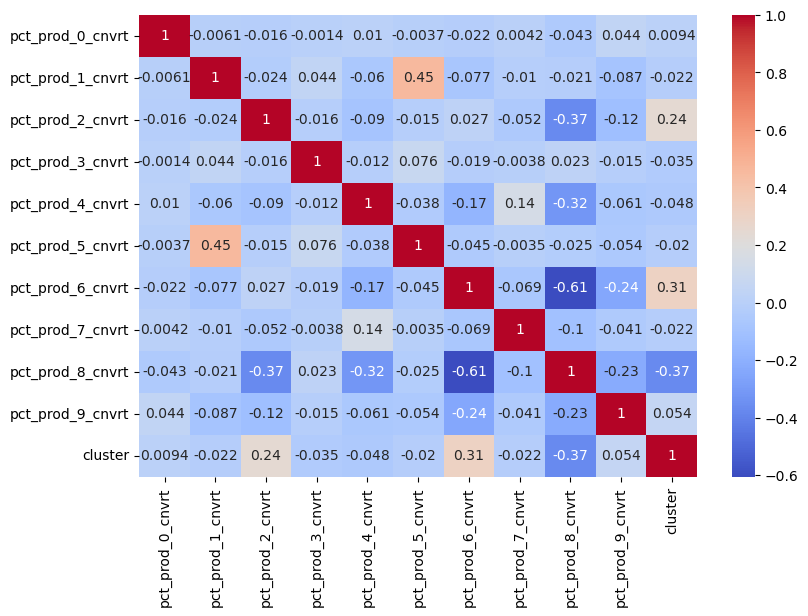

In [208]:
# products_cnvrt = [f"pct_prod_{i}_cnvrt" for i in range(0,10)]
# products_cnvrt+= ["cluster","agent_tenure"]
# print(products_cnvrt)

# correlation_matrix = dfs["agent_encoded"].loc[:,products_cnvrt].corr()

# plt.figure(figsize=(9,6))
# sns.heatmap(correlation_matrix,
#             annot=True,
#             cmap="coolwarm")
# List of product conversion rate columns
products_cnvrt = [f"pct_prod_{i}_cnvrt" for i in range(0, 10)]

# Check if 'cluster' and 'agent_tenure' exist in the DataFrame before adding
if "cluster" in dfs["agent_encoded"].columns:
    products_cnvrt.append("cluster")
if "agent_tenure" in dfs["agent_encoded"].columns:
    products_cnvrt.append("agent_tenure")

print("Final selected columns:", products_cnvrt)

# Compute the correlation matrix only for existing columns
correlation_matrix = dfs["agent_encoded"].loc[:, products_cnvrt].corr()

# Plot the heatmap
plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


⚠️ Warning: The following columns are missing and will be ignored: {'agent_tenure'}


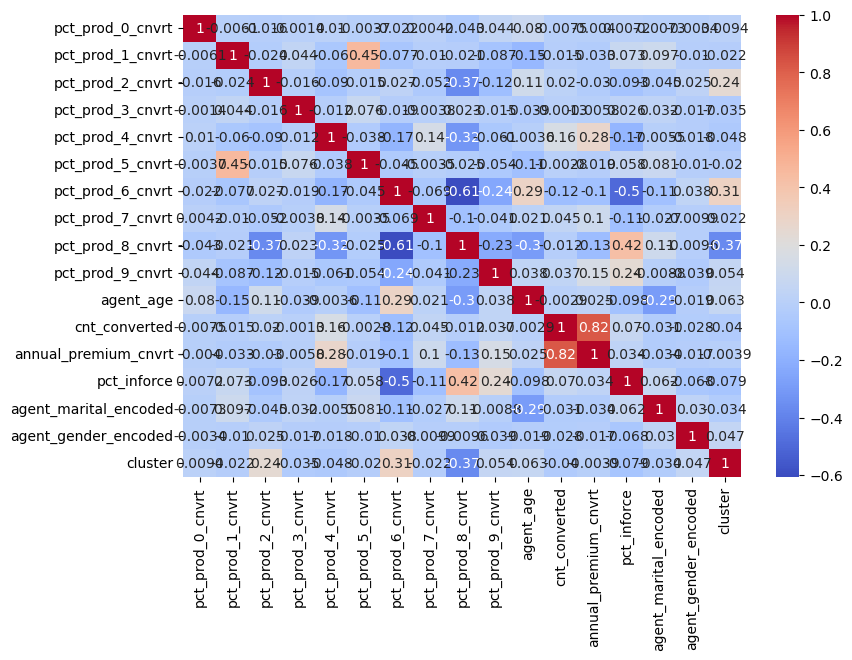

In [209]:
# products_cnvrt = [f"pct_prod_{i}_cnvrt" for i in range(0,10)]
# products_cnvrt += ["agent_age","agent_tenure","cnt_converted","annual_premium_cnvrt","pct_inforce","agent_marital_encoded","agent_gender_encoded","cluster"]
# print(products_cnvrt)

# correlation_matrix = dfs["agent_encoded"].loc[:,products_cnvrt].corr()

# plt.figure(figsize=(9,6))
# sns.heatmap(correlation_matrix,
#             annot=True,
#             cmap="coolwarm")
# Define column names
products_cnvrt = [f"pct_prod_{i}_cnvrt" for i in range(0, 10)]
products_cnvrt += ["agent_age", "agent_tenure", "cnt_converted", "annual_premium_cnvrt",
                   "pct_inforce", "agent_marital_encoded", "agent_gender_encoded", "cluster"]

# Check which columns actually exist
existing_columns = dfs["agent_encoded"].columns
valid_columns = [col for col in products_cnvrt if col in existing_columns]

# Print missing columns (for debugging)
missing_columns = set(products_cnvrt) - set(valid_columns)
if missing_columns:
    print(f"⚠️ Warning: The following columns are missing and will be ignored: {missing_columns}")

# Compute correlation matrix only for valid columns
correlation_matrix = dfs["agent_encoded"].loc[:, valid_columns].corr()

# Plot the heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


In [210]:
print("Indices of Age-based cnvrt:",list(dfs["agent_encoded"].columns).index("pct_AG01_lt20"),":", list(dfs["agent_encoded"].columns).index('pct_AG10_60up'))

Indices of Age-based cnvrt: 20 : 29


In [211]:
age_cnvrt_df = dfs["agent_encoded"].iloc[:,21:30]
age_cnvrt_df["age_total_cnvrt"] = age_cnvrt_df.sum(axis=1)
age_cnvrt_df["agent_age"] = dfs["agent_encoded"]["agent_age"]
age_cnvrt_df["cluster"] = dfs["agent_encoded"]["cluster"]


<Axes: >

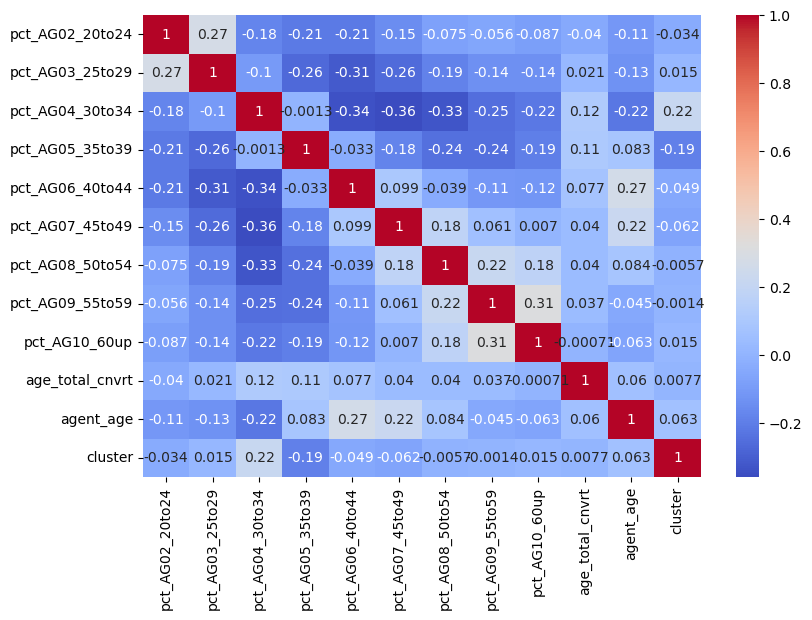

In [212]:
correlation_matrix = age_cnvrt_df.corr()

plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="coolwarm")

⚠️ Warning: The following columns are missing and will be ignored: {'agent_tenure'}


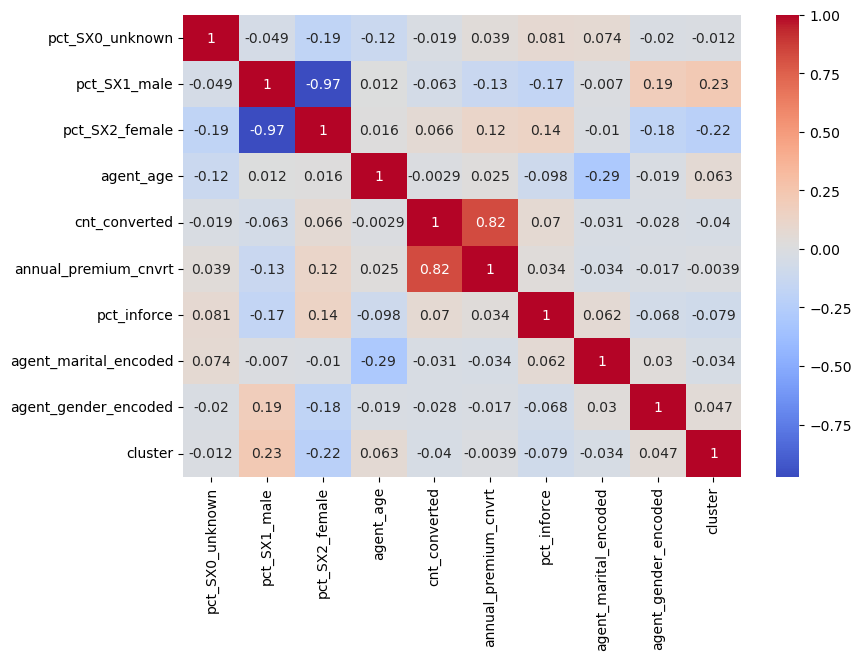

In [213]:
# pct_sex = ["pct_SX0_unknown","pct_SX1_male",	"pct_SX2_female"]
# pct_sex += ["agent_age","agent_tenure","cnt_converted","annual_premium_cnvrt","pct_inforce","agent_marital_encoded","agent_gender_encoded","cluster"]

# correlation_matrix = dfs["agent_encoded"].loc[:,pct_sex].corr()

# plt.figure(figsize=(9,6))
# sns.heatmap(correlation_matrix,
#             annot=True,
#             cmap="coolwarm")
# Define the list of columns
pct_sex = ["pct_SX0_unknown", "pct_SX1_male", "pct_SX2_female",
           "agent_age", "agent_tenure", "cnt_converted", "annual_premium_cnvrt",
           "pct_inforce", "agent_marital_encoded", "agent_gender_encoded", "cluster"]

# Get existing columns from the dataframe
existing_columns = dfs["agent_encoded"].columns

# Filter only valid columns
valid_columns = [col for col in pct_sex if col in existing_columns]

# Print missing columns for debugging
missing_columns = set(pct_sex) - set(valid_columns)
if missing_columns:
    print(f"⚠️ Warning: The following columns are missing and will be ignored: {missing_columns}")

# Compute correlation matrix only for valid columns
correlation_matrix = dfs["agent_encoded"].loc[:, valid_columns].corr()

# Plot the heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()


In [214]:
dfs["agent_encoded"].drop(columns=["pct_SX2_female"],inplace=True) #drop one gender column since high corr

In [215]:
pdts_in_policy_df = dfs["policy"]["product"].unique()
print(len(pdts_in_policy_df), pdts_in_policy_df)

7 ['prod_8' 'prod_6' 'prod_4' 'prod_2' 'prod_9' 'prod_7' 'prod_0']


In [216]:
#Product 1 and 3 cld be dropped
dfs["agent"][[f"pct_prod_{i}_cnvrt" for i in range(0,10)]].sum(axis=0) 

pct_prod_0_cnvrt       5.881897
pct_prod_1_cnvrt     101.835524
pct_prod_2_cnvrt    1010.831442
pct_prod_3_cnvrt       1.866970
pct_prod_4_cnvrt     815.009106
pct_prod_5_cnvrt      19.936241
pct_prod_6_cnvrt    2165.998331
pct_prod_7_cnvrt      75.845880
pct_prod_8_cnvrt    4732.991273
pct_prod_9_cnvrt    1188.468118
dtype: float64

In [217]:
dfs["agent_encoded"].drop(columns=["pct_lapsed"],inplace=True)

In [218]:
dfs["agent_encoded"]

,agntnum,agent_age,cnt_converted,annual_premium_cnvrt,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_gender_encoded,agent_marital_encoded,agent_tenure_grp_encoded
0,AIN:9513,32.0,21.0,1.004900e+04,0.814954,0.000000,0.00000,0.0,0.285714,0.0,0.523810,0.0,0.190476,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.238095,0.142857,0.000000,0.000000,0.000000,0.000000,0.238095,0.142857,0.238095,3,1,1,2.0
1,AIN:4310,40.0,396.0,1.971080e+05,0.083937,0.429293,0.00000,0.0,0.128788,0.0,0.005051,0.0,0.462121,0.000000,0.292929,0.111111,0.000000,0.601010,0.012626,0.012626,0.131313,0.388889,0.116162,0.184343,0.083333,0.020202,0.040404,0.010101,6,1,1,3.0
2,AIN:4302,39.0,853.0,5.106351e+05,0.017406,0.711606,0.00000,0.0,0.242673,0.0,0.083236,0.0,0.436108,0.000000,0.109027,0.128957,0.000000,0.695193,0.010551,0.030481,0.137163,0.144197,0.177022,0.311841,0.106682,0.036342,0.035170,0.010551,6,0,1,3.0
3,AIN:4996,57.0,554.0,3.514724e+05,0.003623,0.584838,0.00000,0.0,0.194946,0.0,0.083032,0.0,0.436823,0.000000,0.061372,0.223827,0.000000,0.397112,0.018051,0.005415,0.009025,0.128159,0.108303,0.234657,0.162455,0.135379,0.160650,0.037906,6,0,0,4.0
4,AIN:3457,38.0,1525.0,1.215380e+06,0.017523,0.640656,0.00000,0.0,0.145574,0.0,0.047869,0.0,0.620328,0.000000,0.114098,0.072131,0.000000,0.626885,0.013115,0.035410,0.069508,0.201311,0.215082,0.214426,0.108197,0.084590,0.043279,0.015082,6,1,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,AIN:2805,34.0,176.0,3.547658e+05,0.022383,0.812500,0.00000,0.0,0.000000,0.0,0.977273,0.0,0.000000,0.022727,0.000000,0.000000,0.000000,0.267045,0.090909,0.051136,0.142045,0.136364,0.034091,0.125000,0.130682,0.079545,0.193182,0.017045,4,0,3,4.0
10125,AIN:6195,33.0,28.0,6.802000e+03,0.000000,0.392857,0.00000,0.0,0.107143,0.0,0.000000,0.0,0.892857,0.000000,0.000000,0.000000,0.000000,0.535714,0.000000,0.071429,0.142857,0.392857,0.000000,0.107143,0.250000,0.035714,0.000000,0.000000,6,1,2,3.0
10126,AIN:8096,45.0,124.0,4.683500e+04,0.000000,0.362903,0.00000,0.0,0.024194,0.0,0.000000,0.0,0.975806,0.000000,0.000000,0.000000,0.000000,0.637097,0.024194,0.072581,0.096774,0.387097,0.088710,0.072581,0.104839,0.129032,0.024194,0.000000,9,1,1,4.0
10127,AIN:389,55.0,2303.0,8.047220e+05,0.000874,0.000000,0.00000,0.0,0.000000,0.0,0.996092,0.0,0.003908,0.000000,0.000000,0.000000,0.000000,0.323491,0.037343,0.148502,0.150673,0.141989,0.145462,0.140252,0.124620,0.082067,0.028224,0.000868,3,0,1,4.0


<h2>EDA for Policy</h2>

In [219]:
dfs["policy"].head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_age_at_purchase_grp,cust_tenure_at_purchase_grp
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,prod_8,1,0,1,0,0,0,1,PG:0,AG05_35to39,TNR2_lt1yr
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,prod_8,1,0,1,0,0,0,1,PG:0,AG04_30to34,TNR4_4to8yr
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,prod_6,1,0,1,0,0,0,1,PG:0,AG07_45to49,TNR4_4to8yr


In [220]:
policy_df = dfs["policy"].copy()
policy_df["cust_tenure_at_purchase_grp"].unique()

encoder = OrdinalEncoder(categories=[['TNR2_lt1yr', 'TNR3_1to4yr','TNR4_4to8yr','TNR5_8yrup']])
policy_df["cust_tenure_at_purchase_grp_encoded"] = encoder.fit_transform(policy_df[["cust_tenure_at_purchase_grp"]])
policy_df.drop(columns=["cust_tenure_at_purchase_grp"],inplace=True)

encoder = OrdinalEncoder(categories=[['AG05_35to39', 'AG04_30to34', 'AG08_50to54', 'AG07_45to49',
       'AG09_55to59', 'AG06_40to44', 'AG10_60up', 'AG03_25to29',
       'AG02_20to24', 'AG01_lt20', 'AG00_missing']])
policy_df["cust_age_at_purchase_grp_encoded"] = encoder.fit_transform(policy_df[["cust_age_at_purchase_grp"]])
policy_df.drop(columns=["cust_age_at_purchase_grp"],inplace=True)
policy_df.head()

policy_df["product"] = policy_df["product"].apply(lambda x: float(x[-1]))
policy_df["product_grp"] = policy_df["product_grp"].apply(lambda x: float(x[-1]))
policy_df.head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_tenure_at_purchase_grp_encoded,cust_age_at_purchase_grp_encoded
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,8.0,1,0,1,0,0,0,1,0.0,0.0,0.0
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,8.0,1,0,1,0,0,0,1,0.0,2.0,1.0
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,6.0,1,0,1,0,0,0,1,0.0,2.0,3.0


In [221]:
dfs["policy_encoded"] = policy_df.copy()

In [222]:
df_merged = pd.merge(dfs['policy_encoded'], dfs['client_encoded'], on='secuityno', how='inner')

df_merged = pd.merge(df_merged, dfs['agent_encoded'], on='agntnum', how='inner')

In [223]:
#Tenure calc: 
# df_merged["occdate"].dt.year - df_merged["cltdob"].dt.year

In [224]:
df_merged.head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_tenure_at_purchase_grp_encoded,cust_age_at_purchase_grp_encoded,cltdob,cltpcode,economic_status,household_size_grp_encoded,family_size_grp_encoded,cltsex_encoded,marryd_encoded,race_desc_map_encoded,client_age,agent_age,cnt_converted,annual_premium_cnvrt,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_gender_encoded,agent_marital_encoded,agent_tenure_grp_encoded
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,8.0,1,0,1,0,0,0,1,0.0,0.0,0.0,1982-03-11,648146,78,1.0,5.0,0,1,0,42,31.0,47.0,6112.000,0.243689,0.936170,0.0,0.212766,0.319149,0.0,0.000000,0.000000,0.042553,0.000000,0.425532,0.00000,0.042553,0.531915,0.000000,0.000000,0.106383,0.148936,0.297872,0.148936,0.191489,0.000000,0.000000,0.000000,1,1,2,2.0
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,8.0,1,0,1,0,0,0,1,0.0,2.0,1.0,1991-03-18,680120,31,2.0,3.0,1,3,0,33,32.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,1,2,4.0
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0,1973-04-16,640818,30,2.0,4.0,1,1,0,51,32.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,1,2,4.0
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,6.0,1,0,1,0,0,0,1,0.0,3.0,2.0,1973-04-16,640818,30,2.0,4.0,1,1,0,51,32.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,1,2,4.0
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,6.0,1,0,1,0,0,0,1,0.0,2.0,3.0,1978-06-20,760401,00,1.0,3.0,0,1,2,46,32.0,4560.0,1045929.756,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,1,2,4.0


In [225]:
[i for i in list(df_merged.columns) if "encoded" in i]

['cust_tenure_at_purchase_grp_encoded',
 'cust_age_at_purchase_grp_encoded',
 'household_size_grp_encoded',
 'family_size_grp_encoded',
 'cltsex_encoded',
 'marryd_encoded',
 'race_desc_map_encoded',
 'agent_gender_encoded',
 'agent_marital_encoded',
 'agent_tenure_grp_encoded']

In [ ]:
# # Drop unnecessary columns
# df_final = df_merged.drop(columns=["occdate","chdrnum", "secuityno", "cluster","cltdob"])


# # Drop original date columns after transformation

# # Define target variable (y) and feature variables (X)
# y = df_final["agntnum"]  # Target: Agent ID
# X = df_final.drop(columns=["agntnum"])  # Features
# X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# # # Apply undersampling only on the training data
# # X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# # Encode categorical variables
# categorical_cols = [
#     "agent_gender_encoded", "agent_marital_encoded", "product", "product_grp",
#     "cust_age_at_purchase_grp_encoded", "cust_tenure_at_purchase_grp_encoded", "cltsex_encoded",
#     "marryd_encoded", "race_desc_map_encoded", "household_size_grp_encoded", "family_size_grp_encoded",
#     "pct_SX1_male",
# ]

    

# # Scale numerical features
# scaler = StandardScaler()
# numerical_cols = [
#     "agent_age", "agent_tenure", "cnt_converted", "annual_premium_cnvrt",
#      "pct_cancel", "pct_inforce", "annual_premium", "pct_AG01_lt20",	
#      "pct_AG02_20to24",	"pct_AG03_25to29",	"pct_AG04_30to34",	"pct_AG05_35to39",	
#      "pct_AG06_40to44",	"pct_AG07_45to49",	"pct_AG08_50to54",	"pct_AG09_55to59",	
#      "pct_AG10_60up"
# ]
# numerical_cols += [f"pct_prod_{i}_cnvrt" for i in range(0,10)]
# X_train_resampled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])

# scaler = StandardScaler()
# X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])
# Step 1: Check which numerical columns exist
existing_numerical_cols = [col for col in numerical_cols if col in X_train_resampled.columns]

# Step 2: Print missing columns for debugging
missing_cols = set(numerical_cols) - set(existing_numerical_cols)
if missing_cols:
    print(f"⚠️ Warning: The following numerical columns are missing and will be ignored: {missing_cols}")

# Step 3: Scale only the existing numerical columns
scaler = StandardScaler()
X_train_resampled[existing_numerical_cols] = scaler.fit_transform(X_train_resampled[existing_numerical_cols])

# Step 4: Apply the same scaling to X_test
existing_test_cols = [col for col in existing_numerical_cols if col in X_test.columns]
X_test[existing_test_cols] = scaler.transform(X_test[existing_test_cols])



⚠️ Warning: The following numerical columns are missing and will be ignored: {'agent_tenure'}


In [227]:
df_final["cust_tenure_at_purchase_grp_encoded"]

0        0.0
1        2.0
2        3.0
3        3.0
4        2.0
        ... 
28965    2.0
28966    0.0
28967    3.0
28968    2.0
28969    1.0
Name: cust_tenure_at_purchase_grp_encoded, Length: 28970, dtype: float64

In [228]:


# Initialize scaler
scaler = MinMaxScaler()

# Compute customer and advisor weights
df_merged["customer_weight"] = df_merged["cust_tenure_at_purchase_grp_encoded"] / df_merged["cust_tenure_at_purchase_grp_encoded"].max()
df_merged["advisor_weight"] = df_merged["agent_tenure_grp_encoded"] / df_merged["agent_tenure_grp_encoded"].max()

# Normalize advisor performance (`annual_premium_cnvrt`)
df_merged["performance_weight"] = df_merged["annual_premium_cnvrt"] / df_merged["annual_premium_cnvrt"].max()

# Compute engineered pct_inforce_score
df_merged["pct_inforce_score"] = (
    df_merged["pct_inforce"] *
    (df_merged["customer_weight"] + df_merged["advisor_weight"]) *
    df_merged["performance_weight"]
)

# Normalize the interaction score for SVD
df_merged["pct_inforce_score"] = scaler.fit_transform(df_merged[["pct_inforce_score"]])



In [229]:
df_merged["pct_inforce_score"] = (
    df_merged["pct_inforce"] * 0.7 + df_merged["pct_inforce_score"] * 0.3
)

In [230]:
# Define reader (Ensure rating_scale matches your data)
reader = Reader(rating_scale=(0, 1))  # Example: Binary interaction (1 = active, 0 = inactive)

# Load dataset
data = Dataset.load_from_df(df_merged[['secuityno', 'agntnum', 'pct_inforce_score']], reader)

# Convert your existing train-test split into Surprise format
trainset = data.build_full_trainset()  # Use all data to train
testset = trainset.build_testset()  # Generate testset for evaluation
model = SVD(n_factors=100, n_epochs=20, random_state=42)
model.fit(trainset)
model = SVD(n_factors=100, n_epochs=20, random_state=42)
model.fit(trainset)
predictions = model.test(testset)
# RMSE (Root Mean Square Error)
rmse_score = accuracy.rmse(predictions)

# MAE (Mean Absolute Error)
mae_score = accuracy.mae(predictions)


RMSE: 0.1186
MAE:  0.0836


In [231]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=20,    # No depth limit (can be tuned)
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster training
)

# Train the model on undersampled data
rf_model.fit(X_train_resampled, y_train_resampled)
# Predict on test set
y_pred = rf_model.predict(X_test)


In [232]:
# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.7081

Classification Report:
              precision    recall  f1-score   support

       AIN:0       1.00      1.00      1.00         1
       AIN:1       1.00      1.00      1.00         1
      AIN:10       0.00      0.00      0.00         2
   AIN:10007       0.00      0.00      0.00         1
   AIN:10009       0.00      0.00      0.00         2
    AIN:1001       1.00      1.00      1.00         3
   AIN:10011       1.00      1.00      1.00         1
   AIN:10012       0.00      0.00      0.00         1
   AIN:10013       0.00      0.00      0.00         1
   AIN:10015       0.00      0.00      0.00         0
    AIN:1002       1.00      1.00      1.00         3
   AIN:10020       1.00      1.00      1.00         2
   AIN:10021       0.00      0.00      0.00         1
   AIN:10024       0.00      0.00      0.00         0
   AIN:10026       0.00      0.00      0.00         1
   AIN:10029       0.00      0.00      0.00         1
   AIN:10031       0.00   

/Users/kaijie/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kaijie/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kaijie/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

In [233]:
# Define reader (Ensure rating_scale matches your data)
reader = Reader(rating_scale=(0, 1))  # Binary interaction (1 = active, 0 = inactive)

# Load dataset
data = Dataset.load_from_df(df_merged[['secuityno', 'agntnum', 'pct_inforce']], reader)

# Convert dataset into Surprise format
trainset = data.build_full_trainset()  # Use all data to train
testset = trainset.build_testset()  # Generate testset for evaluation

# Train SVD model
model = SVD(n_factors=100, n_epochs=20, random_state=42)
model.fit(trainset)

# Predict on test set
predictions = model.test(testset)

# Convert predictions into a DataFrame
pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions],
                       columns=['secuityno', 'agntnum_pred', 'predicted_rating'])

# Merge with the original dataset to get additional features
df_merged_xgb = df_merged.merge(pred_df, on=['secuityno'], how='left')

# Check if there are missing predictions
df_merged_xgb.dropna(subset=['predicted_rating'], inplace=True)

# Step 1: Remove Rare Agents (Less Than 2 Occurrences)**
agent_counts = df_merged_xgb['agntnum'].value_counts()
df_merged_xgb = df_merged_xgb[df_merged_xgb['agntnum'].isin(agent_counts[agent_counts > 1].index)]
print(f"Removed {agent_counts[agent_counts == 1].shape[0]} agents with only 1 occurrence.")

# Ensure categorical variables exist in the dataset before using them
existing_features = [col for col in ['predicted_rating', 'product_grp', 'cust_age_at_purchase_grp_encoded',
                                     'cust_tenure_at_purchase_grp_encoded', 'cluster']
                     if col in df_merged_xgb.columns]

print("Using the following features for training:", existing_features)

# Encode categorical variables
df_merged_xgb[existing_features] = df_merged_xgb[existing_features].astype('category').apply(lambda x: x.cat.codes)

# Define X and y
X = df_merged_xgb[existing_features]
y = df_merged_xgb['agntnum']  # Do NOT encode `y` yet

# Step 2: Split Data First (BEFORE Encoding `y`)**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Encode `y_train` and `y_test` Separately to Avoid Mismatch**
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Ensure `y_test` follows `y_train` mapping

# Step 4: Ensure `y_test` Contains Only Labels Present in `y_train`**
valid_classes = set(y_train_encoded)
mask = np.isin(y_test_encoded, list(valid_classes))  # Filter `y_test` for valid labels
X_test, y_test_encoded = X_test[mask], y_test_encoded[mask]  # Apply filtering

print(f"Adjusted y_test size: {len(y_test_encoded)} (Removed invalid agent labels)")

# Train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=20, learning_rate=0.1, max_depth=6, random_state=42, tree_method = 'hist')
xgb_model.fit(X_train, y_train_encoded)  # Train on encoded `y_train`

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.4f}")


Removed 3379 agents with only 1 occurrence.
Using the following features for training: ['predicted_rating', 'product_grp', 'cust_age_at_purchase_grp_encoded', 'cust_tenure_at_purchase_grp_encoded', 'cluster']
🚀 Adjusted y_test size: 12175 (Removed invalid agent labels)
XGBoost Model Accuracy: 0.4397
